In [ ]:
# ============================================================
# 🧠 PROJECT: Detecting and Reducing Gender Bias in Hiring Data
# ============================================================

"""
📘 PROJECT OVERVIEW:
This notebook demonstrates how to detect and mitigate bias in a hiring dataset.
We'll use a simple dataset with candidate experience, gender, and shortlisting decision.

💡 GOAL:
To identify if gender bias exists in hiring decisions
and show how fairness-aware ML techniques (like Fairlearn) can reduce it.

STEPS COVERED:
1️⃣ Load and explore dataset — check for imbalance and gender-based patterns.
2️⃣ Train two models — one using gender, one without.
3️⃣ Compare model predictions — visualize potential gender bias.
4️⃣ Measure fairness using Disparate Impact (DIR) and Fairlearn metrics.
5️⃣ Apply Fairlearn’s Demographic Parity constraint to reduce bias.

👩‍💻 TOOLS USED:
- pandas, matplotlib, seaborn → Data analysis and visualization
- sklearn → Logistic Regression and evaluation metrics
- fairlearn → Fairness metrics and bias mitigation (Demographic Parity)
"""

✅ First 5 rows of the dataset:
   Gender  Experience  Shortlisted
0    Male           2            0
1  Female          10            1
2    Male           2            0
3    Male          10            1
4    Male           4            1

🔍 Missing values:
Gender         0
Experience     0
Shortlisted    0
dtype: int64

📊 Basic statistics:
       Experience  Shortlisted
count  100.000000    100.00000
mean     5.980000      0.43000
std      2.940418      0.49757
min      1.000000      0.00000
25%      3.000000      0.00000
50%      7.000000      0.00000
75%      8.250000      1.00000
max     10.000000      1.00000

✅ Gender encoding done (Male=0, Female=1):
   Gender  Gender_Encoded
0    Male               0
1  Female               1


/tmp/ipython-input-2196190008.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


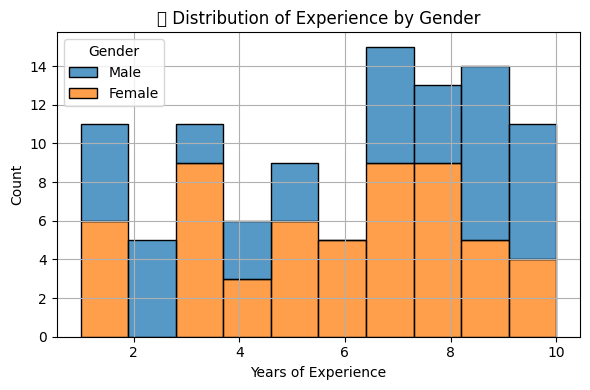

/tmp/ipython-input-2196190008.py:51: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


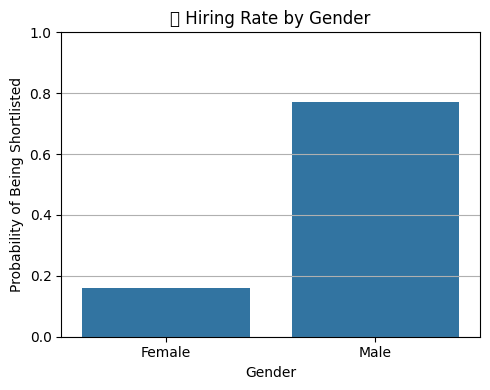


💾 Saved cleaned file to: /content/candidate_data_clean.csv


In [ ]:
# ============================================
# STEP 1: Load and Explore Hiring Dataset (Bias Check Project)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset from Excel file
# In this example we have taken a dataset from internet covering gender, experience and hiring decision.
df = pd.read_excel('/content/Candidate Data.xlsx')

# Show first few rows to understand dataset structure
print("✅ First 5 rows of the dataset:")
print(df.head())

# Check for missing values in each column
print("\n🔍 Missing values:")
print(df.isnull().sum())

# Basic descriptive statistics to understand numeric columns
print("\n📊 Basic statistics:")
print(df.describe())

# Encode Gender column to numeric format: Male=0, Female=1
df['Gender_Encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})

# Confirm encoding worked correctly
print("\n✅ Gender encoding done (Male=0, Female=1):")
print(df[['Gender', 'Gender_Encoded']].drop_duplicates())

# === 🎯 Visual 1: Experience Distribution by Gender ===
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='Experience', hue='Gender', multiple='stack', bins=10)
plt.title('📊 Distribution of Experience by Gender')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 🎯 Visual 2: Hiring Rate by Gender ===
plt.figure(figsize=(5, 4))
hiring_rate = df.groupby('Gender')['Shortlisted'].mean()
sns.barplot(x=hiring_rate.index, y=hiring_rate.values)
plt.title('✅ Hiring Rate by Gender')
plt.ylabel('Probability of Being Shortlisted')
plt.xlabel('Gender')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Save cleaned file for next steps
df.to_csv('/content/candidate_data_clean.csv', index=False)
print("\n💾 Saved cleaned file to: /content/candidate_data_clean.csv")

In [ ]:
# ============================================
# STEP 2: Train and Evaluate Two Models
# ============================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score
)

# Load cleaned data
df = pd.read_csv('/content/candidate_data_clean.csv')

# Define feature sets
# Model A: Includes gender
# Model B: Excludes gender
X_with_gender = df[['Experience', 'Gender_Encoded']]
X_without_gender = df[['Experience']]
y = df['Shortlisted']

# Split into training/testing sets
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_with_gender, y, test_size=0.2, random_state=42)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_without_gender, y, test_size=0.2, random_state=42)

# Train logistic regression models
model_A = LogisticRegression().fit(X_train_A, y_train_A)
model_B = LogisticRegression().fit(X_train_B, y_train_B)

# Predictions and probabilities
probs_A = model_A.predict_proba(X_test_A)[:, 1]
preds_A = model_A.predict(X_test_A)
probs_B = model_B.predict_proba(X_test_B)[:, 1]
preds_B = model_B.predict(X_test_B)

# === Evaluation Function ===
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n🔍 Evaluation: {name}")
    print(f"Accuracy      : {acc:.2f}")
    print(f"Precision     : {prec:.2f}")
    print(f"Recall        : {rec:.2f}")
    print(f"F1 Score      : {f1:.2f}")
    print(f"AUC-ROC       : {auc:.2f}")
    print("Confusion Matrix:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")
    pos_rate = y_true.mean()
    print(f"📊 Positive Rate in Test Data: {pos_rate:.2f}")

# Evaluate both models
evaluate_model("Model A (With Gender)", y_test_A, preds_A, probs_A)
evaluate_model("Model B (Without Gender)", y_test_B, preds_B, probs_B)


🔍 Evaluation: Model A (With Gender)
Accuracy      : 0.95
Precision     : 1.00
Recall        : 0.86
F1 Score      : 0.92
AUC-ROC       : 1.00
Confusion Matrix:
[[13  0]
 [ 1  6]]
True Negatives: 13, False Positives: 0
False Negatives: 1, True Positives: 6
📊 Positive Rate in Test Data: 0.35

🔍 Evaluation: Model B (Without Gender)
Accuracy      : 0.75
Precision     : 0.62
Recall        : 0.71
F1 Score      : 0.67
AUC-ROC       : 0.86
Confusion Matrix:
[[10  3]
 [ 2  5]]
True Negatives: 10, False Positives: 3
False Negatives: 2, True Positives: 5
📊 Positive Rate in Test Data: 0.35


/tmp/ipython-input-2249538621.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_A, x='Gender', y='prob_with_gender', palette="Set2")


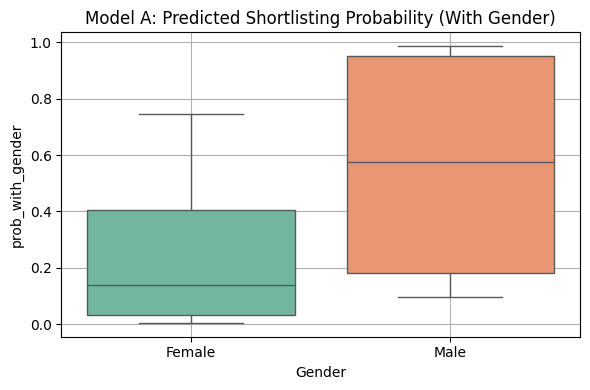

/tmp/ipython-input-2249538621.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_test_B, x='Gender', y='prob_without_gender', palette="Set3")


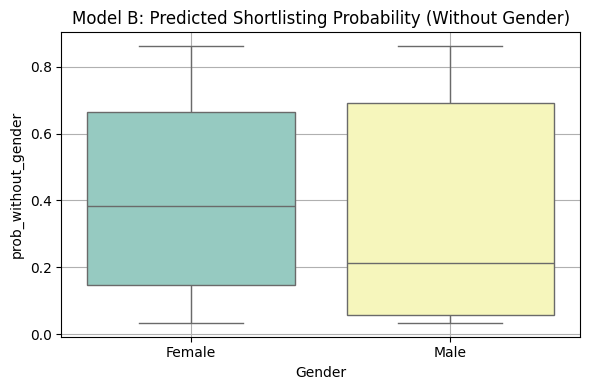

/tmp/ipython-input-2249538621.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_test_A, x='Gender', y='prob_with_gender', inner='quartile', palette="coolwarm")


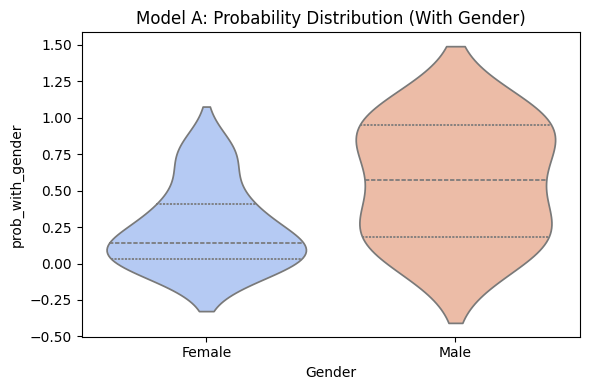

/tmp/ipython-input-2249538621.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=X_test_B, x='Gender', y='prob_without_gender', inner='quartile', palette="coolwarm")


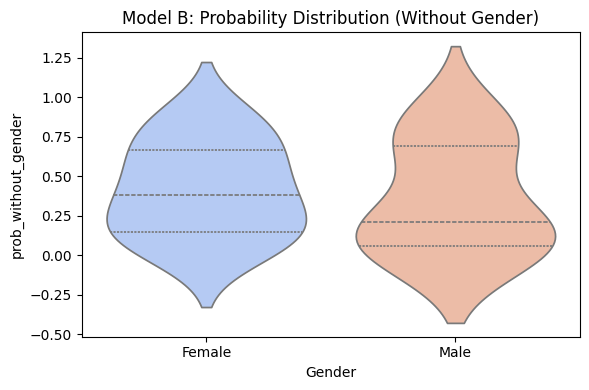


📈 Average Predicted Probability by Gender:

🧠 Model A (With Gender): Gender
Female    0.247840
Male      0.564183
Name: prob_with_gender, dtype: float64

🧠 Model B (Without Gender): Gender
Female    0.416758
Male      0.359805
Name: prob_without_gender, dtype: float64


In [ ]:
# ============================================
# STEP 3: Visual Comparison of Predicted Probabilities by Gender
# ============================================

# Re-run predictions and attach probabilities for plotting
X_test_A = X_test_A.copy()
X_test_B = X_test_B.copy()
X_test_A['Gender'] = df.loc[X_test_A.index, 'Gender']
X_test_A['prob_with_gender'] = model_A.predict_proba(X_test_A[['Experience', 'Gender_Encoded']])[:, 1]
X_test_B['Gender'] = df.loc[X_test_B.index, 'Gender']
X_test_B['prob_without_gender'] = model_B.predict_proba(X_test_B[['Experience']])[:, 1]

# === Boxplot and Violin Plot Visuals ===
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_test_A, x='Gender', y='prob_with_gender', palette="Set2")
plt.title("Model A: Predicted Shortlisting Probability (With Gender)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=X_test_B, x='Gender', y='prob_without_gender', palette="Set3")
plt.title("Model B: Predicted Shortlisting Probability (Without Gender)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Violin plot gives smoother view of probability distributions
plt.figure(figsize=(6, 4))
sns.violinplot(data=X_test_A, x='Gender', y='prob_with_gender', inner='quartile', palette="coolwarm")
plt.title("Model A: Probability Distribution (With Gender)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.violinplot(data=X_test_B, x='Gender', y='prob_without_gender', inner='quartile', palette="coolwarm")
plt.title("Model B: Probability Distribution (Without Gender)")
plt.tight_layout()
plt.show()

# Compare average predicted probability by gender
avg_A = X_test_A.groupby('Gender')['prob_with_gender'].mean()
avg_B = X_test_B.groupby('Gender')['prob_without_gender'].mean()
print("\n📈 Average Predicted Probability by Gender:")
print("\n🧠 Model A (With Gender):", avg_A)
print("\n🧠 Model B (Without Gender):", avg_B)

In [ ]:
# ============================================
# STEP 4: Measure Bias Using Disparate Impact Ratio (DIR)
# ============================================

di_A = avg_A.get('Female', 0) / avg_A.get('Male', 1)
di_B = avg_B.get('Female', 0) / avg_B.get('Male', 1)
print("\n⚖️ Disparate Impact (DIR = Female / Male):")
print(f"Model A (with gender): {di_A:.2f}")
print(f"Model B (without gender): {di_B:.2f}")

# Interpret fairness results (rule of thumb: DIR < 0.8 ⇒ potential bias)
print("\n🔍 Interpretation:")
if di_A < 0.8:
    print("🚨 Model A may exhibit gender bias (DIR < 0.80).")
else:
    print("✅ Model A passes basic fairness check (DIR ≥ 0.80).")

if di_B < 0.8:
    print("🚨 Model B still shows bias — possibly due to proxy effects (e.g., experience correlating with gender).")
else:
    print("✅ Model B is more fair — removing gender helped reduce disparity.")


⚖️ Disparate Impact (DIR = Female / Male):
Model A (with gender): 0.44
Model B (without gender): 1.16

🔍 Interpretation:
🚨 Model A may exhibit gender bias (DIR < 0.80).
✅ Model B is more fair — removing gender helped reduce disparity.


In [ ]:
# ============================================
# STEP 5: Apply Fairlearn – Analyze and Mitigate Bias for Model A ( With Gender)
# ============================================

!pip install fairlearn --quiet

from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
from sklearn.metrics import accuracy_score

# Define sensitive feature (Gender)
sensitive_feature = X_test_A['Gender']

# Predictions from Model A
y_pred = model_A.predict(X_test_A[['Experience', 'Gender_Encoded']])

# Create metric frame to analyze fairness metrics by gender
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'true_positive_rate': true_positive_rate,
    'false_positive_rate': false_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test_A, y_pred=y_pred, sensitive_features=sensitive_feature)
print("\n🎯 Fairness Metrics by Gender:")
print(frame.by_group)

# Calculate disparate impact (selection rate ratio)
selection_rates = frame.by_group['selection_rate']
disparate_impact = selection_rates.get('Female', 0) / selection_rates.get('Male', 1)
print(f"\n⚖️ Disparate Impact (Selection Rate Female / Male): {disparate_impact:.2f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 40.2 MB/s eta 0:00:00

🎯 Fairness Metrics by Gender:
        accuracy  selection_rate  true_positive_rate  false_positive_rate
Gender                                                                   
Female     1.000        0.166667                 1.0                  0.0
Male       0.875        0.500000                 0.8                  0.0

⚖️ Disparate Impact (Selection Rate Female / Male): 0.33


In [ ]:
# ============================================
# STEP 6: Enforce Demographic Parity with Fairlearn GridSearch
# ============================================

from fairlearn.reductions import DemographicParity, GridSearch
from sklearn.linear_model import LogisticRegression

# Define fairness constraint and base model
constraint = DemographicParity()  # Enforces equal selection rates across genders
estimator = LogisticRegression(solver='liblinear')

# Sensitive feature
sensitive = df['Gender_Encoded']
X = df[['Experience']]
y = df['Shortlisted']

# GridSearch finds fair models by adjusting weights/thresholds
mitigator = GridSearch(estimator, constraints=constraint, grid_size=10)
mitigator.fit(X, y, sensitive_features=sensitive)

# Predict using the fairness-constrained model
df['fair_pred'] = mitigator.predict(X)

# Compare selection rates after fairness constraint
print("\n📊 Selection rate (fair model):")
print(df.groupby(df['Gender'])['fair_pred'].mean())

# Compute new disparate impact
sel_rate_female = df[df['Gender'] == 'Female']['fair_pred'].mean()
sel_rate_male = df[df['Gender'] == 'Male']['fair_pred'].mean()
di_fair = sel_rate_female / sel_rate_male
print(f"\n⚖️ Disparate Impact (Fair Model): {di_fair:.2f}")


📊 Selection rate (fair model):
Gender
Female    0.482143
Male      0.590909
Name: fair_pred, dtype: float64

⚖️ Disparate Impact (Fair Model): 0.82


In [ ]:
# ============================================================
# STEP 7: Equalized Odds and Equal Opportunity Constraints
# ============================================================

from fairlearn.reductions import EqualizedOdds, GridSearch
from sklearn.linear_model import LogisticRegression

# --- Equalized Odds: ensures equal TPR & FPR across groups ---
constraint_eqodds = EqualizedOdds()
mitigator_eqodds = GridSearch(LogisticRegression(solver='liblinear'),
                              constraints=constraint_eqodds,
                              grid_size=10)
mitigator_eqodds.fit(X, y, sensitive_features=sensitive)

# Get predictions with Equalized Odds constraint
df['eqodds_pred'] = mitigator_eqodds.predict(X)

# Compute group-level selection rates
sel_rate_eqodds = df.groupby(df['Gender'])['eqodds_pred'].mean()

print("\n⚖️ Selection Rate (Equalized Odds model):")
print(sel_rate_eqodds)

# --- Disparate Impact for Equalized Odds model ---
di_eqodds = sel_rate_eqodds.get('Female', 0) / sel_rate_eqodds.get('Male', 1)
print(f"⚖️ Disparate Impact (Equalized Odds model): {di_eqodds:.2f}")


⚖️ Selection Rate (Equalized Odds model):
Gender
Female    0.321429
Male      0.454545
Name: eqodds_pred, dtype: float64
⚖️ Disparate Impact (Equalized Odds model): 0.71


In [ ]:
# ============================================================
# STEP 8: Equal Opportunity (TPR Parity Only)
# ============================================================

"""
Equal Opportunity focuses on ensuring equal True Positive Rates (TPR)
across sensitive groups — ignoring False Positives.
This is achieved by relaxing EqualizedOdds to only constrain TPRs.
"""

# Custom metric frame to analyze TPR by group
from fairlearn.metrics import true_positive_rate, selection_rate, MetricFrame

# Compute baseline model TPR by group for comparison
y_pred_base = model_A.predict(X_with_gender)
frame_base = MetricFrame(metrics=true_positive_rate,
                         y_true=y,
                         y_pred=y_pred_base,
                         sensitive_features=df['Gender'])
print("\n🎯 Baseline True Positive Rate by Gender:")
print(frame_base.by_group)

# To enforce Equal Opportunity, we’ll use EqualizedOdds
# but during evaluation we’ll only check TPR parity.

mitigator_eqopp = GridSearch(LogisticRegression(solver='liblinear'),
                             constraints=EqualizedOdds(),
                             grid_size=10)
mitigator_eqopp.fit(X, y, sensitive_features=sensitive)
df['eqopp_pred'] = mitigator_eqopp.predict(X)

# Compute TPRs for Equal Opportunity model
frame_eqopp = MetricFrame(metrics=true_positive_rate,
                          y_true=y,
                          y_pred=df['eqopp_pred'],
                          sensitive_features=df['Gender'])
print("\n🎯 True Positive Rate (Equal Opportunity model):")
print(frame_eqopp.by_group)


🎯 Baseline True Positive Rate by Gender:
Gender
Female    1.000000
Male      0.852941
Name: true_positive_rate, dtype: float64

🎯 True Positive Rate (Equal Opportunity model):
Gender
Female    1.000000
Male      0.588235
Name: true_positive_rate, dtype: float64


/tmp/ipython-input-2237323076.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


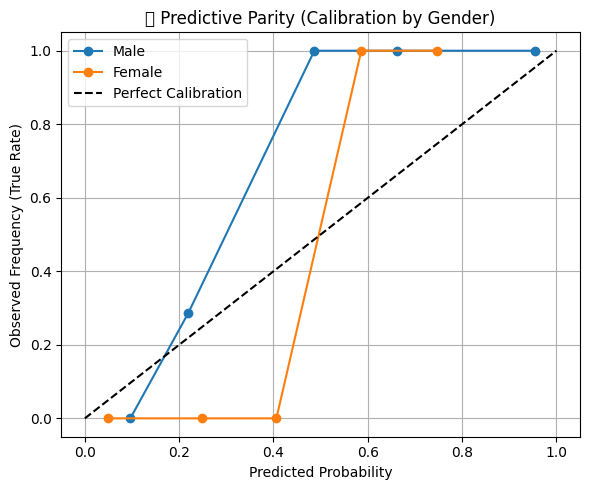


📊 Predictive Parity (AUC by Gender):
Gender
Female    1.0
Male      1.0
Name: roc_auc_score, dtype: float64

AUC Difference (max-min): 0.000


In [ ]:
# ============================================================
# STEP 9: Predictive Parity (Calibration Fairness)
# ============================================================

"""
Predictive Parity means that predicted probabilities have similar meaning
across groups — e.g., 0.8 probability truly corresponds to ~80% chance
for both males and females. We'll measure calibration by group.
"""

from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities from baseline model
probs = model_A.predict_proba(X_with_gender)[:, 1]

# Compute calibration curves by gender
plt.figure(figsize=(6, 5))
for gender_label in df['Gender'].unique():
    mask = df['Gender'] == gender_label
    prob_true, prob_pred = calibration_curve(y[mask], probs[mask], n_bins=6)
    plt.plot(prob_pred, prob_true, marker='o', label=f"{gender_label}")

plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.title("📈 Predictive Parity (Calibration by Gender)")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency (True Rate)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Compute AUC by gender as another predictive parity measure
from sklearn.metrics import roc_auc_score

frame_auc = MetricFrame(metrics=roc_auc_score,
                        y_true=y,
                        y_pred=probs,
                        sensitive_features=df['Gender'])

print("\n📊 Predictive Parity (AUC by Gender):")
print(frame_auc.by_group)
print(f"\nAUC Difference (max-min): {frame_auc.difference():.3f}")


📊 Fairness Metrics Comparison Across Techniques:


,Selection Rate,TPR,FPR,AUC
Baseline (With Gender),0.410,0.926,0.000,1.000
Demographic Parity,0.537,0.882,0.191,0.845
Equalized Odds,0.388,0.794,0.096,0.849
Equal Opportunity,0.388,0.794,0.096,0.849
Predictive Parity (AUC),NaN,NaN,NaN,0.993


/tmp/ipython-input-2985403791.py:110: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


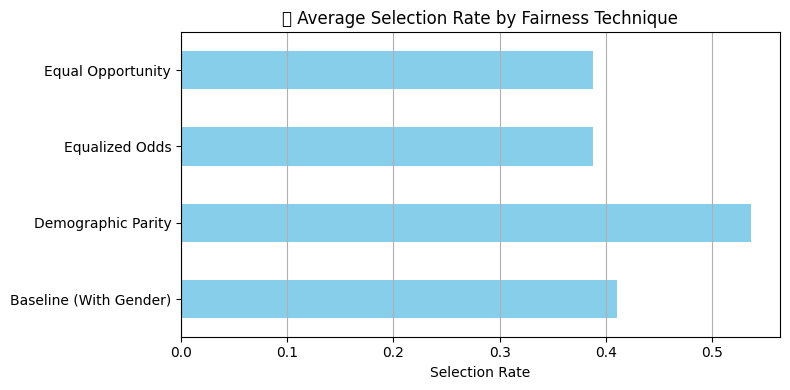

In [ ]:
# ============================================================
# STEP 10: Compare All Fairness Techniques in One Table
# ============================================================

from fairlearn.metrics import selection_rate, true_positive_rate, false_positive_rate
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Create a dictionary to store results from different models
results = {}

# Convert y (Series) to explicit int numpy array for consistency with model predictions
y_np = y.values.astype(bool).astype(int)

# Helper function to calculate metrics for a given model, disaggregated by gender
def calculate_metrics_by_gender(y_true, y_pred, probs, sensitive_features):
    group_metrics = []
    for gender_code in np.unique(sensitive_features):
        mask = (sensitive_features == gender_code)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        probs_group = probs[mask]

        sr = selection_rate(y_true_group, y_pred_group, pos_label=1)

        tpr_val = np.nan
        if np.any(y_true_group == 1): # Calculate TPR only if positive samples exist in the group
            tpr_val = true_positive_rate(y_true_group, y_pred_group, pos_label=1)

        fpr_val = np.nan
        if np.any(y_true_group == 0): # Calculate FPR only if negative samples exist in the group
            fpr_val = false_positive_rate(y_true_group, y_pred_group, pos_label=1)

        auc_val = np.nan
        # Calculate AUC only if both classes are present in y_true_group
        if len(np.unique(y_true_group)) > 1:
            # Removed pos_label=1 from roc_auc_score to fix TypeError
            auc_val = roc_auc_score(y_true_group, probs_group)
        elif len(np.unique(y_true_group)) == 1 and np.unique(y_true_group)[0] == 0:
            auc_val = 0.0 # If only negative class, AUC can be considered 0
        elif len(np.unique(y_true_group)) == 1 and np.unique(y_true_group)[0] == 1:
            auc_val = 1.0 # If only positive class, AUC can be considered 1

        group_metrics.append({
            'Selection Rate': sr,
            'TPR': tpr_val,
            'FPR': fpr_val,
            'AUC': auc_val
        })
    # Return the average of metrics across genders
    return pd.DataFrame(group_metrics).mean(axis=0)

# --- Baseline Model (With Gender) ---
y_pred_base = model_A.predict(X_with_gender).astype(bool).astype(int)
probs_base = model_A.predict_proba(X_with_gender)[:, 1]
results['Baseline (With Gender)'] = calculate_metrics_by_gender(
    y_np, y_pred_base, probs_base, df['Gender_Encoded'].values.astype(int)
)

# --- Demographic Parity Model ---
# For mitigated models, we use their binary predictions for AUC calculation
fair_pred_np = df['fair_pred'].values.astype(bool).astype(int)
results['Demographic Parity'] = calculate_metrics_by_gender(
    y_np, fair_pred_np, fair_pred_np, df['Gender_Encoded'].values.astype(int)
)

# --- Equalized Odds Model ---
eqodds_pred_np = df['eqodds_pred'].values.astype(bool).astype(int)
results['Equalized Odds'] = calculate_metrics_by_gender(
    y_np, eqodds_pred_np, eqodds_pred_np, df['Gender_Encoded'].values.astype(int)
)

# --- Equal Opportunity Model ---
eqopp_pred_np = df['eqopp_pred'].values.astype(bool).astype(int)
results['Equal Opportunity'] = calculate_metrics_by_gender(
    y_np, eqopp_pred_np, eqopp_pred_np, df['Gender_Encoded'].values.astype(int)
)

# --- Predictive Parity (Overall AUC) ---
# This is typically measured by overall model calibration or overall AUC,
# not necessarily an average of group-wise AUCs, if the goal is global parity.
# Calculating overall AUC from the baseline model's probabilities.
# Removed pos_label=1 from roc_auc_score to fix TypeError
overall_auc = roc_auc_score(y_np, probs_base)
results['Predictive Parity (AUC)'] = pd.Series({
    'Selection Rate': np.nan, # Not applicable for overall AUC comparison
    'TPR': np.nan,
    'FPR': np.nan,
    'AUC': overall_auc
})

# Combine all results into one DataFrame
summary_df = pd.DataFrame(results).T

# Round values for readability
summary_df = summary_df.round(3)

# Display comparison table
print("\n📊 Fairness Metrics Comparison Across Techniques:")
display(summary_df)

# Optional: visualize selection rates side-by-side for quick comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
summary_df['Selection Rate'].dropna().plot(kind='barh', color='skyblue')
plt.title("📈 Average Selection Rate by Fairness Technique")
plt.xlabel("Selection Rate")
plt.grid(axis='x')
plt.tight_layout()
plt.show()